In [2]:
#hyödyllisten kirjastojen tuominen
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from collections import Counter
import seaborn as sns

#datasetin lukeminen dataframeiksi
URL= 'http://data.insideairbnb.com/united-states/tx/austin/2021-12-11/data/listings.csv.gz'
Austin_listings = pd.read_csv(URL, compression = 'gzip')
print (Austin_listings)
df2 = pd.read_csv(URL)

df2 = pd.read_csv(URL)
#df2 on aiemminkin luotu dataframe Austinin listauksista
#Valitaan datasta halutut sarakkeet tarkasteluun
df2 = df2[['id','name','price','review_scores_location','review_scores_value','neighborhood_overview','reviews_per_month']]

#Tarkastellaan valitun datasetin arvoja ja poistetaan tyhjät arvot mikäli niitä löydetään

df2.info()
df2.head()

             id                            listing_url       scrape_id  \
0          1078      https://www.airbnb.com/rooms/1078  20211211051409   
1          2265      https://www.airbnb.com/rooms/2265  20211211051409   
2          5245      https://www.airbnb.com/rooms/5245  20211211051409   
3          5456      https://www.airbnb.com/rooms/5456  20211211051409   
4          5769      https://www.airbnb.com/rooms/5769  20211211051409   
...         ...                                    ...             ...   
11369  53760016  https://www.airbnb.com/rooms/53760016  20211211051409   
11370  53764066  https://www.airbnb.com/rooms/53764066  20211211051409   
11371  53767190  https://www.airbnb.com/rooms/53767190  20211211051409   
11372  53769566  https://www.airbnb.com/rooms/53769566  20211211051409   
11373  53770692  https://www.airbnb.com/rooms/53770692  20211211051409   

      last_scraped                                               name  \
0       2021-12-11                  *U

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11374 entries, 0 to 11373
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      11374 non-null  int64  
 1   name                    11374 non-null  object 
 2   price                   11374 non-null  object 
 3   review_scores_location  8743 non-null   float64
 4   review_scores_value     8743 non-null   float64
 5   neighborhood_overview   6827 non-null   object 
 6   reviews_per_month       8831 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 622.1+ KB


,id,name,price,review_scores_location,review_scores_value,neighborhood_overview,reviews_per_month
0,1078,*UT/Hyde Park Craftsman Apartment,$102.00,4.87,4.87,"Hyde Park is close to downtown, UT, 6th street...",1.44
1,2265,Zen-East in the Heart of Austin (monthly rental),$179.00,4.26,4.35,NaN,0.17
2,5245,"Eco friendly, Colorful, Clean, Cozy monthly share",$114.00,4.75,4.50,NaN,0.06
3,5456,"Walk to 6th, Rainey St and Convention Ctr",$104.00,4.73,4.78,My neighborhood is ideally located if you want...,3.72
4,5769,NW Austin Room,$39.00,4.74,4.92,Quiet neighborhood with lots of trees and good...,1.86


In [3]:
#Katsottiin vielä arvoista paljonko löytyy NaN-arvoja 
print(df2.isnull().sum())

id                           0
name                         0
price                        0
review_scores_location    2631
review_scores_value       2631
neighborhood_overview     4547
reviews_per_month         2543
dtype: int64


In [4]:
#Muutettiin NaN-arvot nolliksi
df2['review_scores_location'].fillna(0, inplace=True)
df2['review_scores_value'].fillna(0, inplace=True)
df2['neighborhood_overview'].fillna(0, inplace=True)
df2['reviews_per_month'].fillna(0, inplace=True)
#Tarkastetaan ettei tyhjiä arvoja enää ole 
#neighborhood_overviewin olisi mahdollisesti voinut vaihtaa tyhjäksi merkkijonoksi, mutta en ollut toteutuksesta aivan varma
print(df2.isnull().sum())
#Muutettiin hinta float-arvoksi ja poistettiin dollari merkit ja tuhat erottimet
df2['price'] = df2['price'].str.replace('$','', regex = True)
df2['price'] = df2['price'].str.replace(',','')
df2['price'] = df2['price'].astype(float)

id                        0
name                      0
price                     0
review_scores_location    0
review_scores_value       0
neighborhood_overview     0
reviews_per_month         0
dtype: int64


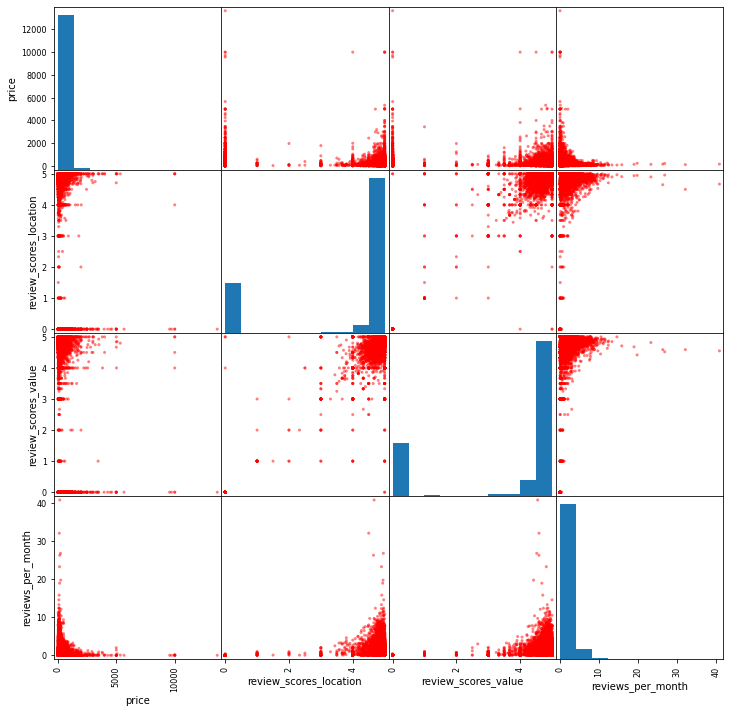

In [5]:
scattercols = ['price','review_scores_location','review_scores_value','reviews_per_month']
axs = pd.plotting.scatter_matrix(df2[scattercols], figsize =(12,12), color = 'red')

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'price'}>],
       [<AxesSubplot:title={'center':'review_scores_location'}>,
        <AxesSubplot:title={'center':'review_scores_value'}>],
       [<AxesSubplot:title={'center':'reviews_per_month'}>,
        <AxesSubplot:>]], dtype=object)

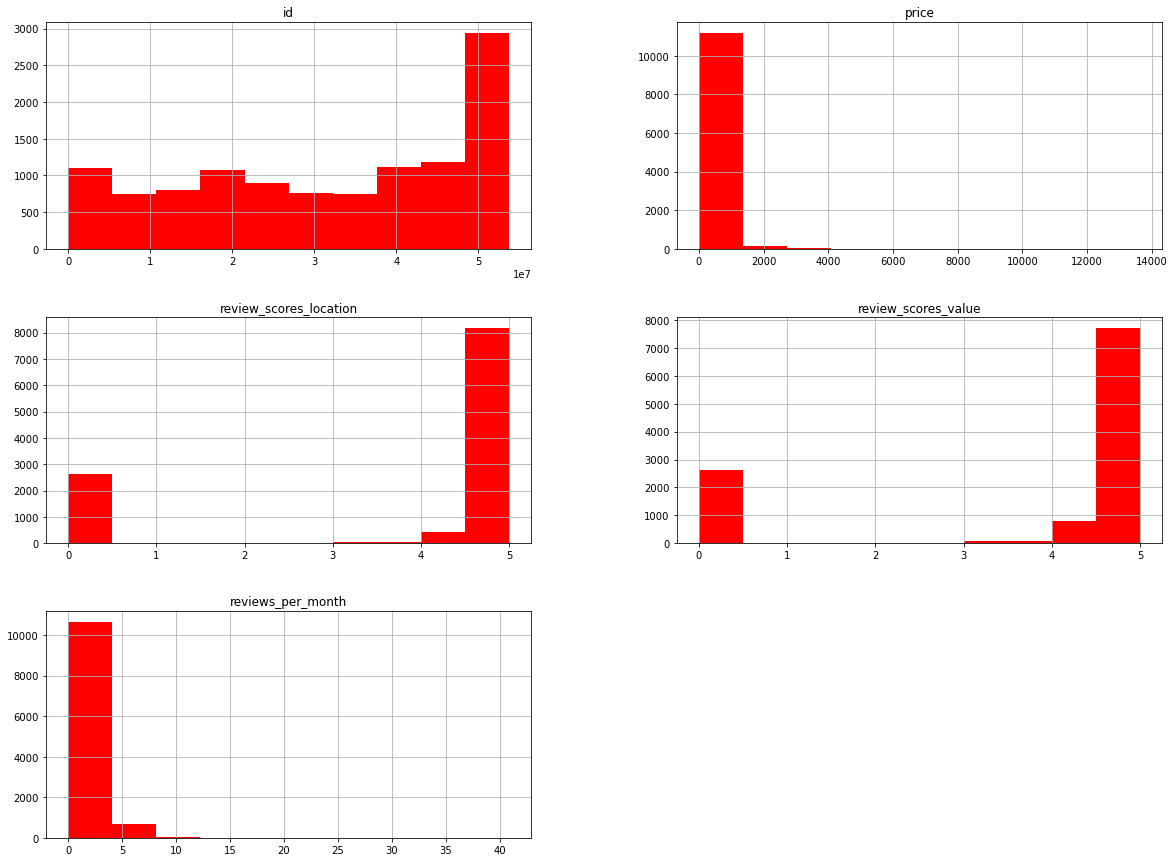

In [6]:
#Muodostettiin datasta histogrammit
df2.hist(figsize = (20,15), color = 'red')

<AxesSubplot:xlabel='review_scores_value'>

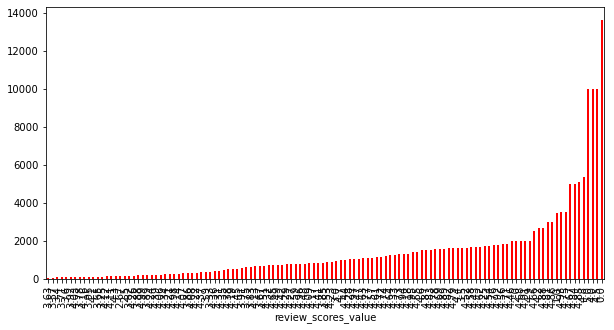

In [7]:
#Tarkasteltiin miten arvostelun arvosanat ja asunnon hinta vaikuttavat keskenään
groups = df2.groupby('review_scores_value')['price']
groups.max().sort_values().plot(kind = 'bar', figsize=(10,5), color = 'red')

In [8]:
#Tutkitaan miten toiset muuttujat korreloivat hinnan kanssa
print(df2.corr()['price'])

id                       -0.049826
price                     1.000000
review_scores_location   -0.100619
review_scores_value      -0.107425
reviews_per_month        -0.109179
Name: price, dtype: float64


In [9]:
#Tämän mukaisesti näyttäisi siltä ettei hinta korreloi minkään valitun muuttujan kanssa
#Tarkastellaan seuraavaksi korrelaatiota arvostelu tuloksien kanssa
print(df2.corr()['review_scores_value'])

id                       -0.094895
price                    -0.107425
review_scores_location    0.988759
review_scores_value       1.000000
reviews_per_month         0.368772
Name: review_scores_value, dtype: float64


In [10]:
#Mielestäni tässä näyttäisi olevan jonkinlaista korrelaatiota arvioiden sijainnin sekä arvioiden kuukausittaisen määrän kanssa
#Halusin vielä tarkastella arvioiden sijainnin korrelaatiota
print(df2.corr()['review_scores_location'])

id                       -0.088268
price                    -0.100619
review_scores_location    1.000000
review_scores_value       0.988759
reviews_per_month         0.362871
Name: review_scores_location, dtype: float64


Text(0, 0.5, 'Arvostelujen pisteet')

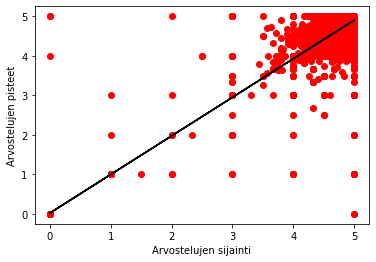

In [15]:
#Tässä näyttäisi olevan korrelaatiota samoihin arvoihin kuin jo yllä mainittiin mikä kävisi järkeen
#Siirryttiin tarkastelemaan lineaarista regressiota valitulla dataframella
lr = linear_model.LinearRegression()
x = df2['review_scores_location'].values[:, np.newaxis]
y = df2['review_scores_value']
classifier = lr.fit(x,y)
plt.scatter(x,y, color = 'red')
plt.plot(x,classifier.predict(x), color = 'black')
plt.xlabel('Arvostelujen sijainti')
plt.ylabel('Arvostelujen pisteet')


Text(0, 0.5, 'Arvostelujen määrä/kk')

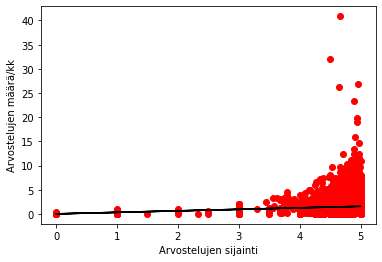

In [17]:
#Vaikka tässä kuvaaja näyttäisikin lineerisen regression selkeäksi, ovat tulokset mielestäni silti hyvin hajanaisia
#Halusin vielä tarkastella miltä pienemmän korrelaation tapaus näyttäisi
lr = linear_model.LinearRegression()
x = df2['review_scores_location'].values[:, np.newaxis]
y = df2['reviews_per_month']
classifier = lr.fit(x,y)
plt.scatter(x,y, color = 'red')
plt.plot(x,classifier.predict(x), color = 'black')
plt.xlabel('Arvostelujen sijainti')
plt.ylabel('Arvostelujen määrä/kk')


In [ ]:
#Tässä regressio on paljon maltillisempi vaikka se on vieläkin kuvaajasta havaittavissa